In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
from sklearn_pandas import DataFrameMapper
%matplotlib inline

# Parameters

In [2]:
list(zip(range(2001,2020),string.ascii_lowercase))

[(2001, 'a'),
 (2002, 'b'),
 (2003, 'c'),
 (2004, 'd'),
 (2005, 'e'),
 (2006, 'f'),
 (2007, 'g'),
 (2008, 'h'),
 (2009, 'i'),
 (2010, 'j'),
 (2011, 'k'),
 (2012, 'l'),
 (2013, 'm'),
 (2014, 'n'),
 (2015, 'o'),
 (2016, 'p'),
 (2017, 'q'),
 (2018, 'r'),
 (2019, 's')]

In [3]:
s,e = 'a','s'
min_start_age = 25

# Data Structure

- part1 contains the combined data from all questionairs asked in a given wave. Each wave is a separate file (eg a s wave 1, be is wave 2, etc. 

In [4]:
# variables that have a positive and negative version can be compressed to a single variable

In [64]:
df1, meta1 = pyreadstat.read_sav(f'part1/Combined {s}190c.sav')
n0 = len(df1)

In [67]:
df1 = df1[df1[f'{s}hgage'] >= min_start_age]
print(f"Dropping {n0-len(df1)} participants below age {min_start_age}")

# filter out those already studying

# If any of the following are > 0, then the respondant was already studying at the beginning of the period
already_studying_cols = [s+col for col in ['caeft','caept','nlreast','bncsty','bnfsty']]

already_studying = df1[already_studying_cols].sum(axis=1)

n0 = len(df1)
df1 = df1[already_studying < 1].copy()
print(f"Dropping {n0-len(df1)} participants already studying at period start")

# compute initial qualifications count
edu = [c for c in df1.columns if re.match(s+r'edq\d{3}$',c)]
df1['initial_qualn'] = df1[edu].sum(axis=1)

Dropping 0 participants below age 25
Dropping 1216 participants already studying at period start


In [68]:
# compute final qualifications count
df2, meta2 = pyreadstat.read_sav(f'part1/Combined {e}190c.sav')
edu = [c for c in df2.columns if re.match(e+r'edq\d{3}$',c)]
df2['final_qualn'] = df2[edu].sum(axis=1)

In [69]:
df = pd.merge(df1,df2,how="inner",on=['xwaveid'],suffixes=('','_post'))
len(df)

5604

In [70]:
df['initial_qualn'].sum()

5538.0

In [71]:
df['final_qualn'].sum()

8015.0

## Predict who will gain a qualification

In [11]:
# Task 1, predict who gains a qualification

# What are the most important predictors?

# How predictive are these factors?

# Dataset 
#    - People observed over 25 in 2008 who are still in the sample in 2019. 

# We can get the data from intermediate waves, but it will be missing for some people. 

# need to narrow it so as to only consider those over 25 (and presumably who are not currently studying?)

In [82]:
df['delta_qual'] = df['final_qualn'] - df['initial_qualn']
df['gained_qual'] = df['delta_qual'] > 0

In [14]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import VarianceThreshold

In [110]:
def is_valid_column(colname, coltype):
    exclude_prefix = [
        'edcq','bnfsty','edcqfpt','edqstdy' # all relate to qualifications currently being studied
    ]
    if coltype == 'object':
        return False
    for p in exclude_prefix:
        if colname[1:].startswith(p):
            return False
    return True

cols = [colname for (colname, coltype) in df1.dtypes.items() if is_valid_column(colname,coltype)]  


#'aehtseyr', 'D2 Years since left full-time education')
# ('aehttot', 'D3 Total years since left school - Manual addition')

In [111]:
missing = df[cols].isnull().mean(axis=0)
valid = missing[missing < 0.98].index
X = df[valid]
y = df['gained_qual']
print("proportion gaining qualification:",y.mean())
print("X dimensions:",X.shape)

proportion gaining qualification: 0.26891506067094934
X dimensions: (5604, 1910)


In [112]:
# drop all columns that have 0 variance
v = VarianceThreshold()
v.fit(X)
features = X.columns[v.get_support()]
X = df[features]

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)

In [114]:
pipeline = make_pipeline(
        SimpleImputer(),
        StandardScaler(),
        LogisticRegressionCV(penalty='l2',max_iter=1000, Cs=np.logspace(-6,0,10))
)

In [115]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=array([1.00000000e-06, 4.64158883e-06, 2.15443469e-05, 1.00000000e-04,
       4.64158883e-04, 2.15443469e-03, 1.00000000e-02, 4.64158883e-02,
       2.15443469e-01, 1.00000000e+00]),
                                      max_iter=1000))])

In [149]:
c = X.corr()
c = c.where(np.triu(np.ones(c.shape)).astype(np.bool))

In [150]:
threshold = 0.95
redundent = c[c > threshold].stack().reset_index()
redundent.columns = ['col1','col2','c']

In [151]:
redundent

,col1,col2,c
0,ahhstate,ahhstate,1.000000
1,ahhstate,ahhmsr,0.972089
2,ahhstate,ahhsgcc,0.967359
3,xhhstrat,xhhstrat,1.000000
4,ahhcalls,ahhcalls,1.000000
...,...,...,...
3924,arwsc45,arwsc45,1.000000
3925,arwsc45,ahhwtscs,0.953511
3926,ahhwtscs,ahhwtscs,1.000000
3927,ascmatch,ascmatch,1.000000


In [153]:
redundent = redundent[redundent['col1']!= redundent['col2']]
redundent.sort_values('col1') # take one with least missing data. 

,col1,col2,c
3031,abifiga,aiorea,1.000000
3032,abifiga,ajst,1.000000
1286,abifin,abifn,1.000000
1284,abifip,abifp,0.999913
1154,abncallf,abncpenf,0.991500
...,...,...,...
3026,awsfga,awsfe,0.977659
3025,awsfga,awsfg,0.977659
453,axpfood,axpfoodi,1.000000
451,axpgroc,axpgroci,1.000000


In [155]:
d = set(redundent['col2'])
len(d)

718

In [ ]:
d

In [ ]:
tmp = df[]

In [143]:
df = df.where(np.triu(np.ones(df.shape)).astype(np.bool))
print df
    a    b    c
a   1  0.5  0.3
b NaN  1.0  0.4
c NaN  NaN  1.0

df = df.stack().reset_index()
df.columns = ['Row','Column','Value']
print df

In [142]:
for indx, vals in c.iterrows():
    print(vals[vals > 0.99])

ahhstate    1.0
Name: ahhstate, dtype: float64
xhhstrat    1.0
Name: xhhstrat, dtype: float64
ahhcalls    1.0
Name: ahhcalls, dtype: float64
ahhresp    1.0
Name: ahhresp, dtype: float64
ahhpers    1.0
Name: ahhpers, dtype: float64
ahgage1    1.0
Name: ahgage1, dtype: float64
ahgage2    1.0
Name: ahgage2, dtype: float64
ahgage3    1.0
Name: ahgage3, dtype: float64
ahgage4    1.0
Name: ahgage4, dtype: float64
ahgage5     1.0
amrpwidw    1.0
Name: ahgage5, dtype: float64
ahgage6    1.0
Name: ahgage6, dtype: float64
ahgsex1    1.0
Name: ahgsex1, dtype: float64
ahgsex2    1.0
Name: ahgsex2, dtype: float64
ahgsex3    1.0
Name: ahgsex3, dtype: float64
ahgsex4    1.0
Name: ahgsex4, dtype: float64
ahgsex5     1.0
amrpwidw    1.0
Name: ahgsex5, dtype: float64
ahgsex6     1.000000
ajsreahd    1.000000
acaj0325    1.000000
acaj0326    1.000000
acaj0327    1.000000
acaj0328    1.000000
acaj0329    1.000000
awscmna     0.995307
awscmsup    1.000000
abnfaph     1.000000
Name: ahgsex6, dtype: float64


ahhinthq    1.0
Name: ahhinthq, dtype: float64
ahgagf2    1.0
Name: ahgagf2, dtype: float64
ahgagf3    1.0
Name: ahgagf3, dtype: float64
ahhiu01    1.0
Name: ahhiu01, dtype: float64
ahhiu02    1.0
Name: ahhiu02, dtype: float64
ahhiu03    1.0
Name: ahhiu03, dtype: float64
ahhiu04    1.0
Name: ahhiu04, dtype: float64
ahhiu05     1.0
ajsactat    1.0
Name: ahhiu05, dtype: float64
ahhiu06    1.000000
arcdayn    0.993178
Name: ahhiu06, dtype: float64
abnftaf1    1.0
Name: abnftaf1, dtype: float64
abnftaf2    1.0
Name: abnftaf2, dtype: float64
abnftbf1    1.0
Name: abnftbf1, dtype: float64
abnftbf2    1.0
Name: abnftbf2, dtype: float64
abnmatf1    1.0
Name: abnmatf1, dtype: float64
abnmatf2    1.0
Name: abnmatf2, dtype: float64
ahifftb     1.000000
ahiffama    0.998975
ahifnisi    0.993238
Name: ahifftb, dtype: float64
ahifmat    1.0
Name: ahifmat, dtype: float64
ahifftb     0.998975
ahiffama    1.000000
ahifnisi    0.994094
Name: ahiffama, dtype: float64
ahiwscei    1.00000
ahiwscmi    0.993

aedqoc3    1.0
Name: aedqoc3, dtype: float64
aedqoc4    1.0
Name: aedqoc4, dtype: float64
aedqocd    1.0
Name: aedqocd, dtype: float64
aedqodp    1.0
Name: aedqodp, dtype: float64
aedqoav    1.0
Name: aedqoav, dtype: float64
aedqobd    1.0
Name: aedqobd, dtype: float64
aedqohd    1.0
Name: aedqohd, dtype: float64
aedqogd    1.0
Name: aedqogd, dtype: float64
aedqoms    1.0
Name: aedqoms, dtype: float64
aedqodc    1.0
aedq110    1.0
Name: aedqodc, dtype: float64
aedqobc    1.0
Name: aedqobc, dtype: float64
aedqosc    1.0
Name: aedqosc, dtype: float64
aedqocc    1.0
Name: aedqocc, dtype: float64
aedqogc    1.0
aedq221    1.0
Name: aedqogc, dtype: float64
aedqocn    1.0
Name: aedqocn, dtype: float64
aedqodn    1.0
Name: aedqodn, dtype: float64
aedqnone    1.0
Name: aedqnone, dtype: float64
aedqnei    1.0
Name: aedqnei, dtype: float64
aedqoos    1.0
Name: aedqoos, dtype: float64
aedqodk    1.0
Name: aedqodk, dtype: float64
aedqnnq    1.0
Name: aedqnnq, dtype: float64
aedqntq    1.0
Name: ae

acaj0247    1.0
abncap      1.0
arcngtnp    1.0
arcdaynp    1.0
Name: acaj0247, dtype: float64
acaj0248    1.0
abncap      1.0
Name: acaj0248, dtype: float64
adorfsex    1.0
acaj03fp    1.0
awscmsup    1.0
abnfdspw    1.0
amrwdur     1.0
Name: acaj03fp, dtype: float64
arg06_03    1.0
arg06_04    1.0
anlreapc    1.0
acaj0149    1.0
acaj0150    1.0
acaj0151    1.0
acaj0301    1.0
acaj0302    1.0
awscmna     1.0
abnfdspw    1.0
arcefs2     1.0
Name: acaj0301, dtype: float64
arg06_03    1.0
arg06_04    1.0
anlreapc    1.0
acaj0149    1.0
acaj0150    1.0
acaj0151    1.0
acaj0301    1.0
acaj0302    1.0
awscmna     1.0
abnfdspw    1.0
arcefs2     1.0
Name: acaj0302, dtype: float64
arg06_03    1.0
arg06_04    1.0
anlreapc    1.0
acaj0149    1.0
acaj0150    1.0
acaj0151    1.0
acaj0303    1.0
awscmna     1.0
abnfdspw    1.0
arcefs2     1.0
Name: acaj0303, dtype: float64
anlreapc    1.0
acaj0149    1.0
acaj0150    1.0
acaj0151    1.0
acaj0304    1.0
awscmna     1.0
abnfdspw    1.0
arcefs2     1.

acanlf49    1.0
acanlf50    1.0
acanlf51    1.0
anculv2     1.0
Name: anculv2, dtype: float64
ahgms5      1.000000
ahges5      1.000000
achh_sf     1.000000
achh_re     0.999833
acpctc      1.000000
acpu_fd     1.000000
acpctci     1.000000
acaj0328    1.000000
acaj0329    1.000000
acaj0330    1.000000
acaj0331    1.000000
acaj0332    1.000000
acaj0333    1.000000
acaj0334    1.000000
acaj0335    1.000000
acaj0336    1.000000
acaj0337    1.000000
acaj0338    1.000000
acaj0339    1.000000
acaj0340    1.000000
acaj0341    1.000000
acaj0342    1.000000
anculv3     1.000000
arcpew4     1.000000
arcefs2     1.000000
arcngtn     0.995228
Name: anculv3, dtype: float64
ancefs1    1.0
Name: ancefs1, dtype: float64
ancefs2    1.0
Name: ancefs2, dtype: float64
achh_sf     1.0
acaune43    1.0
acaune44    1.0
acaune45    1.0
acanlf43    1.0
acanlf44    1.0
acanlf45    1.0
ancefs3     1.0
arcngtnp    1.0
Name: ancefs3, dtype: float64
ancofs1    1.0
Name: ancofs1, dtype: float64
ancofs2    1.0
Name: 

agh6    1.0
Name: agh6, dtype: float64
agh7    1.0
Name: agh7, dtype: float64
agh8    1.0
Name: agh8, dtype: float64
agh9a    1.0
Name: agh9a, dtype: float64
agh9b    1.0
Name: agh9b, dtype: float64
agh9c    1.0
Name: agh9c, dtype: float64
agh9d    1.0
Name: agh9d, dtype: float64
agh9e    1.0
Name: agh9e, dtype: float64
agh9f    1.0
Name: agh9f, dtype: float64
agh9g    1.0
Name: agh9g, dtype: float64
agh9h    1.0
Name: agh9h, dtype: float64
agh9i    1.0
Name: agh9i, dtype: float64
agh10    1.0
Name: agh10, dtype: float64
agh11a    1.0
Name: agh11a, dtype: float64
agh11b    1.0
Name: agh11b, dtype: float64
agh11c    1.0
Name: agh11c, dtype: float64
agh11d    1.0
Name: agh11d, dtype: float64
alspact    1.0
Name: alspact, dtype: float64
alssmoke    1.0
Name: alssmoke, dtype: float64
alstbca    1.0
Name: alstbca, dtype: float64
alsdrink    1.0
Name: alsdrink, dtype: float64
alsstddr    1.0
Name: alsstddr, dtype: float64
alsrush    1.0
Name: alsrush, dtype: float64
alsstime    1.0
Name: als

In [127]:
(coef['coef']>0).sum()

860

In [116]:
model = pipeline['logisticregressioncv']
coef = pd.DataFrame({"coef":model.coef_[0]},index=X.columns)
coef['abs'] = coef['coef'].abs()
top_coef = coef.sort_values('abs',ascending=False).head(100)


['aedqenr',
 'artage2',
 'afibeduc',
 'afisass',
 'afibcar',
 'ajbnewjs',
 'ahgyob',
 'ahgage',
 'ahhiage',
 'ajbmwpsz',
 'aehtjbyr',
 'aehtjb',
 'ahgsex',
 'aehtseyr',
 'aehttot',
 'aehtse',
 'amhn10yr',
 'ajbocct',
 'aedfts',
 'amrpyr',
 'aedqotq',
 'initial_qualn',
 'aloimpyh',
 'aicage1',
 'atcnr',
 'ajboccyr',
 'aedq524',
 'aehhasto',
 'acpno',
 'alshaas',
 'aloimphl',
 'alsstddr',
 'acsu_oe',
 'amrcdur',
 'adorisex',
 'ahhyng',
 'atcn25',
 'aordf1mt',
 'acsh_sf',
 'awslyha',
 'alosatfs',
 'adolgni',
 'achu_na',
 'abnfyth',
 'ahglth5',
 'aedhigh1',
 'ajbemlyr',
 'afiprosp',
 'afibfin',
 'acsctc',
 'aioinflu',
 'achu_vs',
 'alslaat',
 'ajsminws',
 'aednrspn',
 'awsfhave',
 'acanlf42',
 'ajbempt',
 'acpc_re',
 'ahgage2',
 'amhreani',
 'amhl10yr',
 'acsctci',
 'ancany',
 'ajsreale',
 'aoifinh',
 'ahhold',
 'ajbmshrs',
 'anlreamh',
 'anlan4wk',
 'ajbmssec',
 'alosatnl',
 'amhreabn',
 'aedq511',
 'ajsreano',
 'acsu_fo',
 'acsu_na',
 'aednrsbh',
 'arcngtn',
 'aujyru',
 'ahges2',
 'abnft

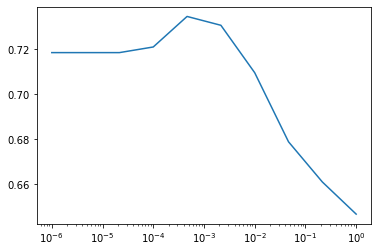

In [119]:
plt.semilogx(model.Cs_,model.scores_[True].mean(axis=0))
# smaller values of C => more regularisation

In [118]:
m = meta1.column_names_to_labels

In [120]:
for line in [(v,m.get(v,v)) for v in top_coef.index]:
    print(line)

('aedqenr', 'C6 Ever enrolled in a course of study to obtain a qualification')
('artage2', 'F21 Check age 45 or older')
('afibeduc', 'SCQ:C7e Alright to borrow for - Education')
('afisass', 'SCQ:C3b How would obtain (waves 1-8) $2,000 (waves 9+) $3,000 - Sell an asset')
('afibcar', 'SCQ:C7d Alright to borrow for - Car')
('ajbnewjs', 'E37 At any time in the last 4 weeks, have you actually looked for a new job')
('ahgyob', 'HF4 Year of Birth')
('ahgage', 'DV: Age last birthday at June 30 2001')
('ahhiage', 'DV: Age last birthday at date of interview')
('ajbmwpsz', 'E33 Number employed at place of work')
('aehtjbyr', 'D3a1 Years in paid work')
('aehtjb', 'DV: Time in paid work - years')
('ahgsex', 'HF3 Sex')
('aehtseyr', 'D2 Years since left full-time education')
('aehttot', 'D3 Total years since left school - Manual addition')
('aehtse', 'DV: Time since FT education - years')
('amhn10yr', 'K12 How many homes lived in during last 10 years')
('ajbocct', 'DV: Tenure in current occupation (y

In [24]:
#hedcq - "enrolled"
# If they are studying at the start, we would need to check if they were over 25 when that course of study began. 

In [25]:
# 'History: Time since FT education - years'

In [26]:
#meta08.variable_value_labels["hhges2"]

In [121]:
prob = pipeline.predict_proba(X_test)[:,1]

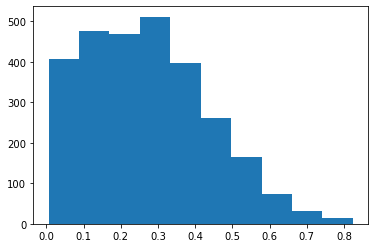

In [122]:
plt.hist(prob);

In [123]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, prob)

ROC AUC 0.72


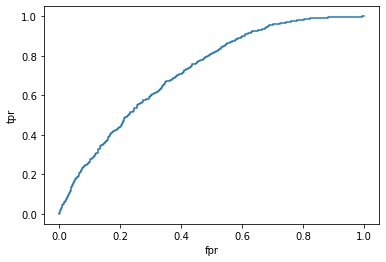

In [124]:
plt.plot(fpr,tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
print(f"ROC AUC {roc_auc_score(y_test,prob):.2f}")